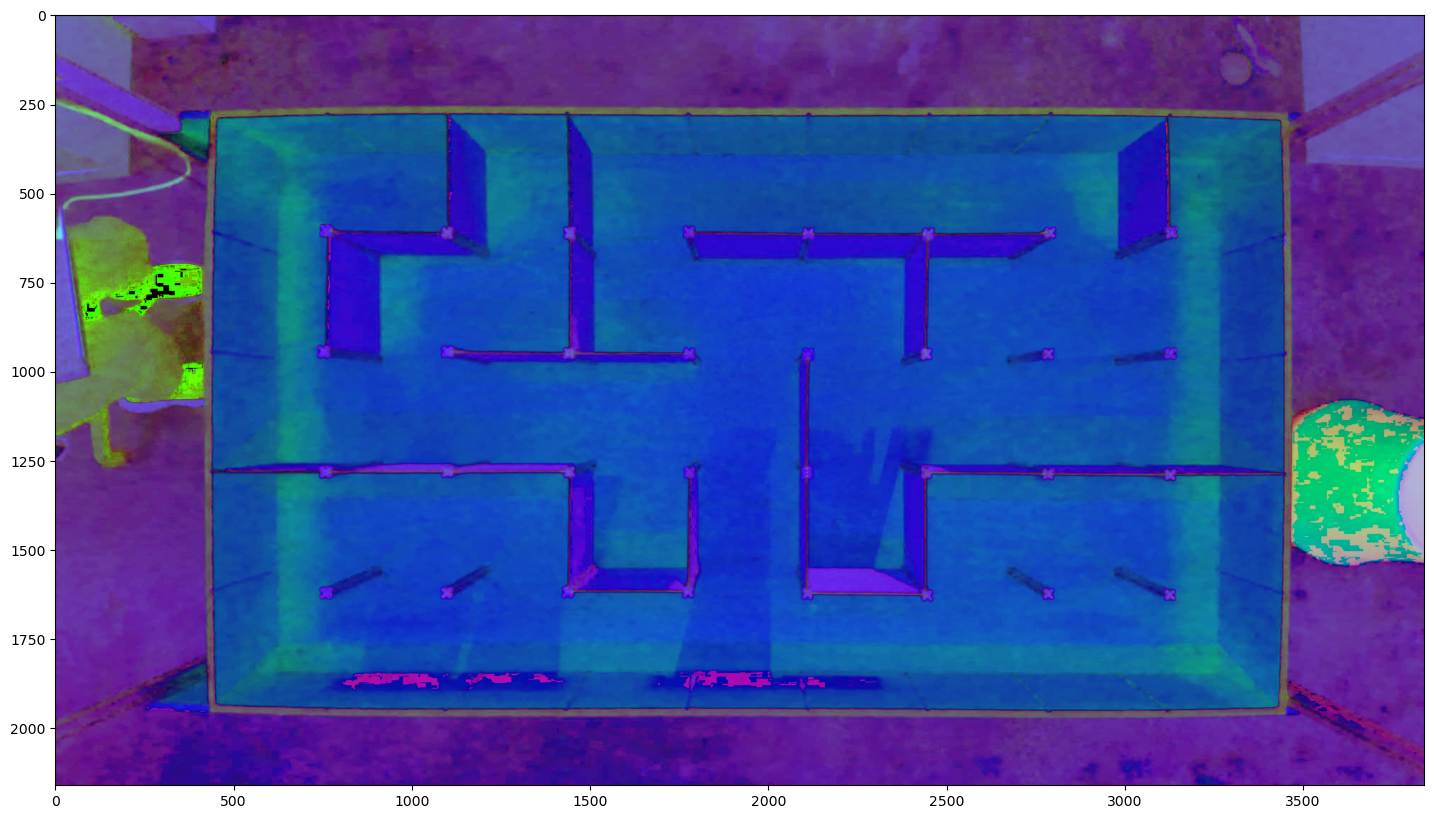

In [14]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting

## Read
img = cv2.imread('replace with ...')

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.figure(figsize = (18,10))
plt.imshow(hsv)
plt.show()

[[ 8.47457627e-01  7.49400542e-16 -3.81355932e+02]
 [-1.80411242e-16  1.00000000e+00 -3.00000000e+02]
 [ 1.08420217e-19  3.79470760e-19  1.00000000e+00]]


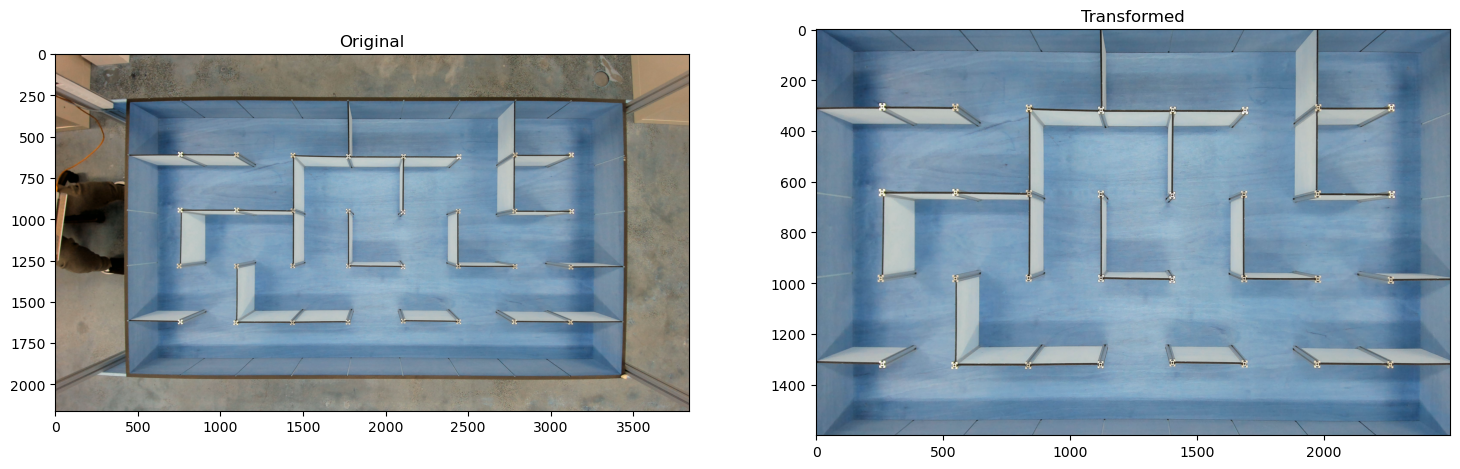

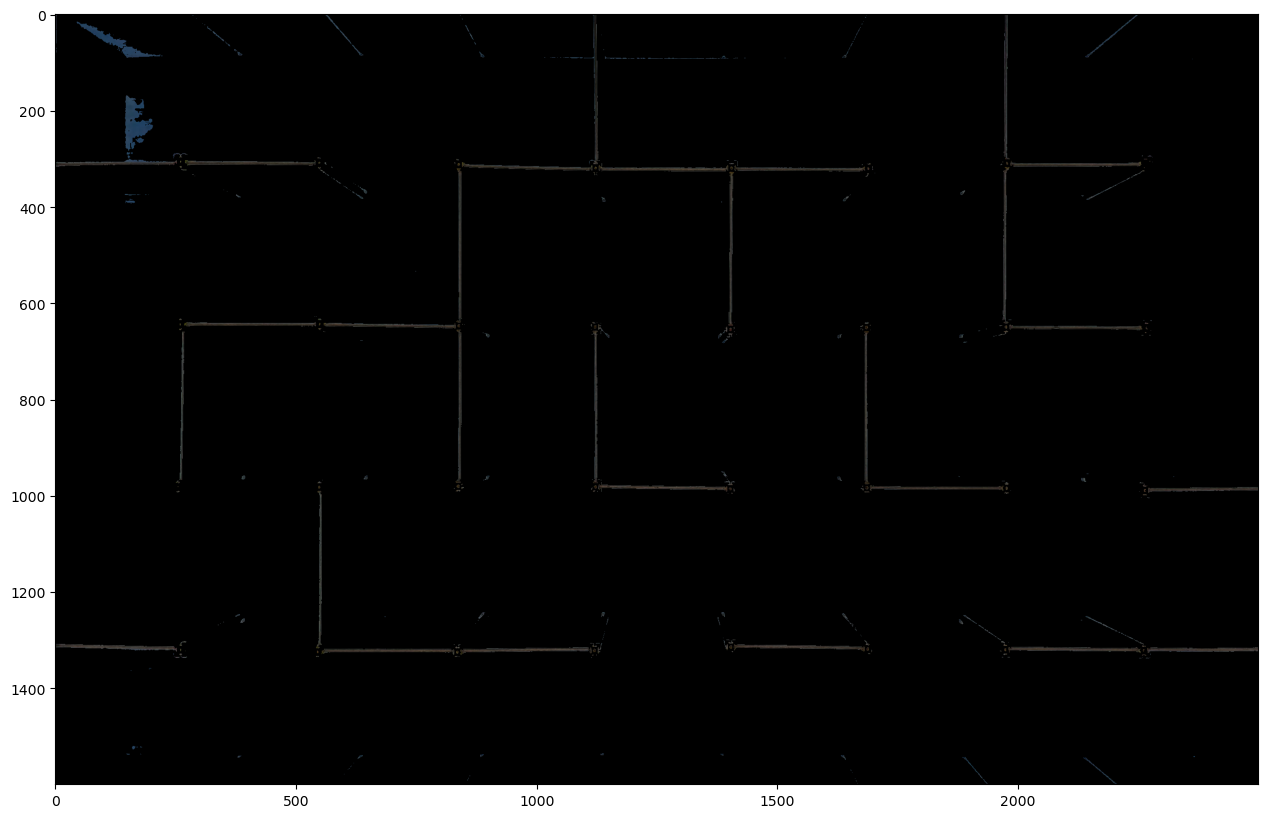

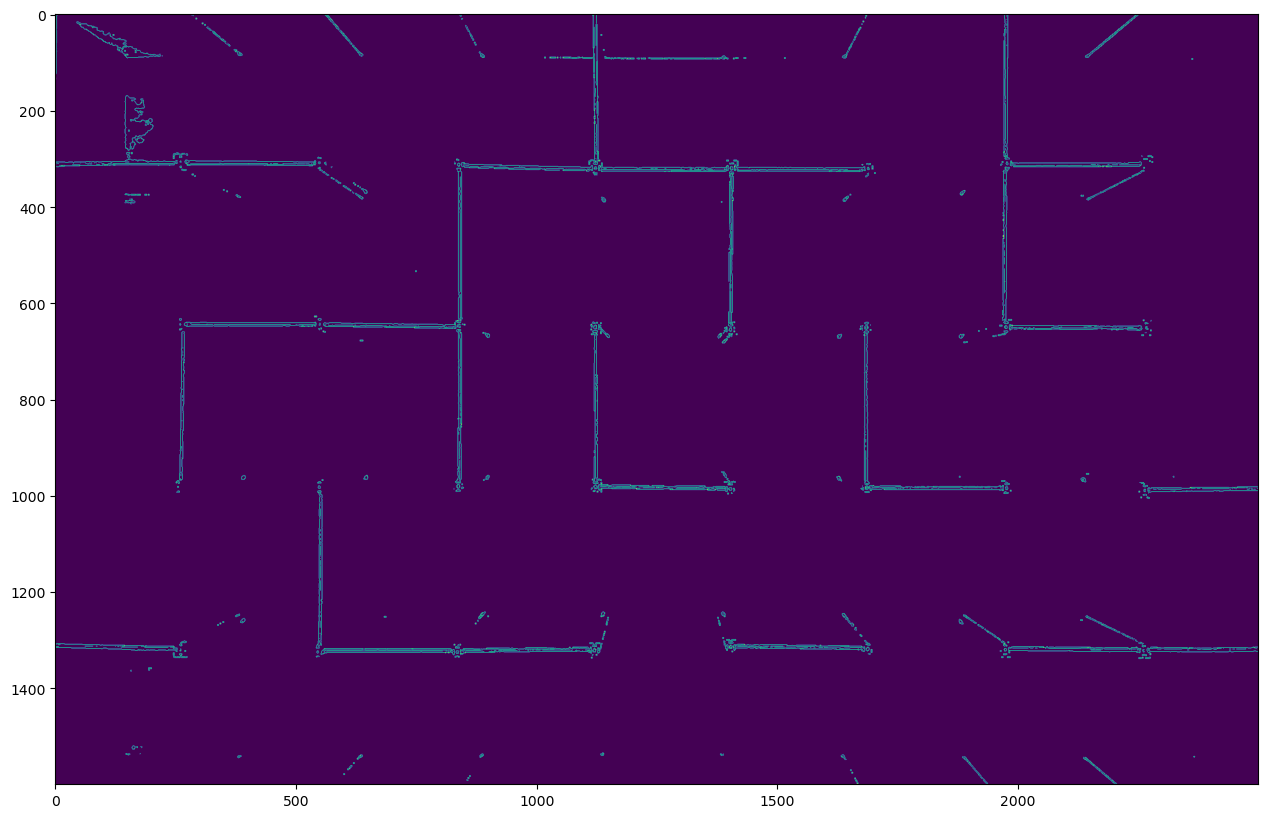

ValueError: too many values to unpack (expected 2)

In [39]:
## Perspective tranformation
img = cv2.imread('replace with ...') # read an image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

##pts1 = np.float32([[100,200],[2300,200],[100,1410],[2300,1410]]) # four points on the first image
pts1 = np.float32([[450,300],[3400,300],[450,1900],[3400,1900]]) # four points on the first image
pts2 = np.float32([[0,0],[2500,0],[0,1600],[2500,1600]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)

dst = cv2.warpPerspective(img, H, (2500,1600))

fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(img), ax1.set_title("Original")
ax2.imshow(dst), ax2.set_title("Transformed")
plt.show()

# NOTE: may have to adjust the maxV threshold and/or the kernal size depending on image...
hsv = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
mask1 = cv2.inRange(hsv, (0, 0, 0), (179, 255, 100))
imask1 = mask1>0
wall_mask = np.zeros_like(dst, np.uint8)
wall_mask[imask1] = dst[imask1]

plt.figure(figsize = (18,10))
plt.imshow(wall_mask)
plt.show()

img_gray = cv2.cvtColor(wall_mask, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img_gray, threshold1 = 50, threshold2 = 100, apertureSize = 3)
plt.figure(figsize = (18,10))
plt.imshow(edges)
plt.show()

contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(dst, contours, -1, (255, 0, 0), 3)
img_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (18,10))
plt.imshow(img_rgb)
plt.show()


In [40]:
# Find all connected components and get the statistics for each component
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges, connectivity=8)
# Define a threshold, connected components with an area smaller than this will be removed
thresh = 100
# For each connected component
for i in range(1, num_labels):
    # If the area of the connected component is smaller than the threshold
    if stats[i, cv2.CC_STAT_AREA] < thresh:
        # Remove this connected component
        edges[labels == i] = 0

# dilate walls
kernel = np.ones((50, 50), np.uint8)
processed_walls = cv2.dilate(edges, kernel, iterations = 2)

# Generate a map and write it to a text file
file = open("./Map.txt", 'w')
map = []
# draw the outside frame of the map
for x in range(11):
    row = []
    for y in range(19):
        if(y % 2 == 0):
            if(y == 0 or y == 18):
                if(x % 2 == 0):
                    row.append(" ")
                else:
                    row.append("|")       
            else:
                row.append(" ")    # gap between ---
        else:
            if(x == 0 or x == 10):
                row.append("---") 
            else:
                row.append("   ")
    map.append(row)


horizontal = np.zeros((5,9))
vertical = np.zeros((5,9))

for x in range(5):
    for y in range(9):
        if processed_walls[x * 320][y * 277 + 138] != 0:
            horizontal[x][y] = 1
        if processed_walls[x * 320 + 160][y * 277] != 0:
            vertical[x][y] = 1
    
for x in range(5):
    for y in range(9):
        if(horizontal[x][y]):
            map[x * 2][y * 2 + 1] = ("---")
        if(vertical[x][y]):
            map[x * 2 + 1][y * 2] = ("|")

for i in range(len(map)):
    for j in range(len(map[i])):
        file.write(map[i][j])
    if (i != len(map) - 1):
        file.write("\n")

file.close()